In [1]:
import numpy as np
import os
from astropy.table import Table, vstack
from tensorflow import keras
from tensorflow.keras import layers
import elk  # Ensure you have the correct import for elk
from sklearn.model_selection import train_test_split

# Load and preprocess data
data = Table.read('Stats_Table_For_Data_augmented_lcs_v2.fits')
data.add_column([0 for i in range(len(data))], name='Stitched')
sector_stitched = Table.read('Stats_Table_For_Sector_Stitched.fits')
sector_stitched.add_column([1 for i in range(len(sector_stitched))], name='Stitched')
data = vstack([data, sector_stitched])

# Create labels and features
features = ['rms', 'std', 'MAD', 'sigmaG', 'von_neumann_ratio', 'J_Stetson', 'freq_at_max_power',
            'SumLSP_10_7_Day_Power', 'SumLSP_7_4_Day_Power', 'SumLSP_4_1_Day_Power', 'SumLSP_1_p5_Day_Power']

# Load and preprocess light curves
path = '/Users/Tobin/Dropbox/TESS_project/HLSPs/'
gal_list = ['MW', 'SMC', 'LMC']
l_of_cs = []

for gal in gal_list:
    filenames = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(path + gal + "_Final_V2/")) for f in fn]
    for file in filenames:
        l_of_cs.append(elk.ensemble.from_fits(file))

l_of_all_lcs = []
for lc in l_of_cs:
    for sub_lc in lc.lcs:
        corrected_lc = sub_lc.corrected_lc
        corrected_lc['flux_err'] /= np.median(corrected_lc['flux'])
        corrected_lc['flux'] /= np.median(corrected_lc['flux'])
        l_of_all_lcs.append(corrected_lc)

# Generate sector stitched light curves
l_of_stitched_lcs = []
stitched_names = []  # To store names for sector stitched light curves
for i in range(len(l_of_cs)):
    stitched_fluxes = []
    stitched_times = []
    stitched_flux_errs = []
    for j in range(len(l_of_cs[i].lcs)):
        stitched_fluxes.append(l_of_cs[i].lcs[j].normalized_flux)
        stitched_times.append(l_of_cs[i].lcs[j].corrected_lc.time.value)
        stitched_flux_errs.append(l_of_cs[i].lcs[j].corrected_lc.flux_err.value / np.median(l_of_cs[i].lcs[j].corrected_lc.flux.value))

    catted_fluxes = np.concatenate(stitched_fluxes)
    catted_flux_errs = np.concatenate(stitched_flux_errs)
    catted_times = np.concatenate(stitched_times)
    
    stitched_table = Table([catted_times, catted_fluxes, catted_flux_errs], names=('time', 'flux', 'flux_err'))
    l_of_stitched_lcs.append(stitched_table)
    stitched_names.append(l_of_cs[i].callable)  # Assign the correct name

def find_12_day_window(light_curve):
    window_duration = 12
    total_duration = light_curve['time'][-1] - light_curve['time'][0]
    if total_duration < window_duration:
        raise ValueError("Light curve is shorter than the window duration")
    num_points = len(light_curve)
    max_start_index = num_points - int(num_points * (window_duration / total_duration.value))
    windows = [light_curve.iloc[start_index:start_index + int(num_points * (window_duration / total_duration.value))]
               for start_index in np.arange(0, (max_start_index + 1), 100)]
    return windows

data_augmented_lcs = []
for lc in l_of_all_lcs:
    data_augmented_lcs.append(lc)
    data_augmented_lcs.append(lc[:int(len(lc) / 2)])
    data_augmented_lcs.append(lc[int(len(lc) / 2):])
    data_augmented_lcs.extend(find_12_day_window(lc))

# Add sector stitched light curves to data_augmented_lcs
data_augmented_lcs.extend(l_of_stitched_lcs)

# Match light curves with data
# Assuming 'names' list matches the order of light curves with the 'data' table
names = []
for lc in l_of_cs:
    for sub_lc in lc.lcs:
        names.extend([lc.callable] * (3 + len(find_12_day_window(sub_lc.corrected_lc))))
names.extend(stitched_names)  # Add names for sector stitched light curves

# Ensure each light curve is an array of flux values
X_lc_list = [lc['flux'].data for lc in data_augmented_lcs]

# Find the maximum length of the light curves
max_length = max(len(lc) for lc in X_lc_list)

# Pad the light curves to the maximum length
X_lc_padded = np.array([np.pad(lc, (0, max_length - len(lc)), 'constant') for lc in X_lc_list])

# Reshape to (samples, time_steps, 1)
X_lc = X_lc_padded.reshape((X_lc_padded.shape[0], X_lc_padded.shape[1], 1))

# Ensure X_features matches the number of samples in X_lc
X_features = np.array([data[feature] for feature in features]).T[:X_lc.shape[0]]

# Split data based on names
unique_names = np.unique(names)
train_names, test_names = train_test_split(unique_names, test_size=0.2, random_state=42)

train_indices = np.isin(names, train_names)
test_indices = np.isin(names, test_names)

X_lc_train, X_lc_test = X_lc[train_indices], X_lc[test_indices]
X_features_train, X_features_test = X_features[train_indices], X_features[test_indices]
y_train, y_test = data['Lit_Clst_Age'][train_indices], data['Lit_Clst_Age'][test_indices]

# Identify and weight the 'sector_stitched' data using the 'Stitched' column
sample_weights = np.ones(len(y_train))
sample_weights[data['Stitched'][train_indices] == 1] *= 1.1  # Increase weight by 10%

# Define and compile the multi-input model for regression
input_lc = layers.Input(shape=(X_lc.shape[1], 1), name='light_curve')
input_features = layers.Input(shape=(len(features),), name='features')


2024-10-21 16:56:36.228969: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/Tobin/opt/anaconda3/envs/elk/lib/python3.10/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/Tobin/.lightkurve/cache. Please move all the files in the legacy directory /Users/Tobin/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [2]:
print("That's good!")

That's good!


In [5]:
# Light curve branch
x_lc = layers.Conv1D(32, kernel_size=3, activation='relu')(input_lc)
x_lc = layers.MaxPooling1D(pool_size=2)(x_lc)
x_lc = layers.Conv1D(64, kernel_size=3, activation='relu')(x_lc)
x_lc = layers.MaxPooling1D(pool_size=2)(x_lc)
x_lc = layers.Flatten()(x_lc)

# Combine branches
x = layers.concatenate([x_lc, input_features])
x = layers.Dense(100, activation='relu')(x)
output = layers.Dense(1)(x)  # Regression output

model = keras.Model(inputs=[input_lc, input_features], outputs=output)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='mean_squared_error',
    metrics=['mae']
)



In [6]:
# Train the model
history = model.fit(
    {'light_curve': X_lc_train, 'features': X_features_train},
    y_train,
    sample_weight=sample_weights,
    batch_size=32,
    epochs=100,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=10, verbose=1, min_delta=1e-5),
        keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=1e-5, patience=10, verbose=1)
    ],
    verbose=1
)

# Evaluate the model
test_loss, test_mae = model.evaluate(
    {'light_curve': X_lc_test, 'features': X_features_test},
    y_test
)
print(f'Test MAE: {test_mae}')

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Plot predicted vs actual values for the test set
y_pred = model.predict({'light_curve': X_lc_test, 'features': X_features_test})
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

Epoch 1/100
950/950 ━━━━━━━━━━━━━━━━━━━━ 1849s 2s/step - loss: 1.5877 - mae: 0.6900 - val_loss: 0.6401 - val_mae: 0.4239 - learning_rate: 0.0010
Epoch 2/100
950/950 ━━━━━━━━━━━━━━━━━━━━ 1863s 2s/step - loss: 0.3561 - mae: 0.4745 - val_loss: 0.7736 - val_mae: 0.4154 - learning_rate: 0.0010
Epoch 3/100
950/950 ━━━━━━━━━━━━━━━━━━━━ 1840s 2s/step - loss: 0.3379 - mae: 0.4626 - val_loss: 0.8526 - val_mae: 0.4686 - learning_rate: 0.0010
Epoch 4/100
950/950 ━━━━━━━━━━━━━━━━━━━━ 1837s 2s/step - loss: 0.3352 - mae: 0.4602 - val_loss: 0.7880 - val_mae: 0.4850 - learning_rate: 0.0010
Epoch 5/100
950/950 ━━━━━━━━━━━━━━━━━━━━ 1836s 2s/step - loss: 0.3155 - mae: 0.4450 - val_loss: 0.5483 - val_mae: 0.4314 - learning_rate: 0.0010
Epoch 6/100
950/950 ━━━━━━━━━━━━━━━━━━━━ 2784s 3s/step - loss: 0.3119 - mae: 0.4432 - val_loss: 0.5198 - val_mae: 0.3975 - learning_rate: 0.0010
Epoch 7/100
950/950 ━━━━━━━━━━━━━━━━━━━━ 1825s 2s/step - loss: 0.2903 - mae: 0.4265 - val_loss: 0.5564 - val_mae: 0.4213 - learnin

NameError: name 'plt' is not defined

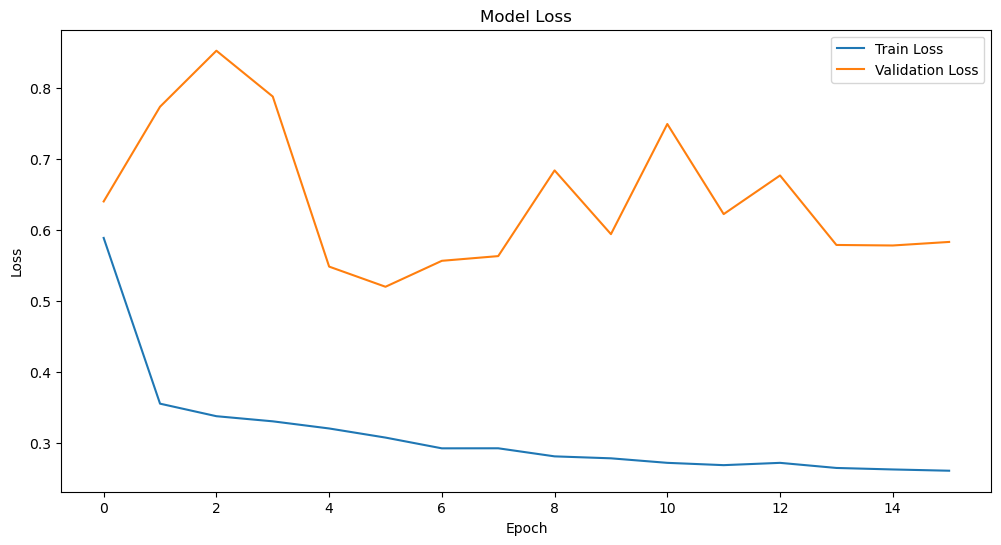

290/290 ━━━━━━━━━━━━━━━━━━━━ 151s 517ms/step


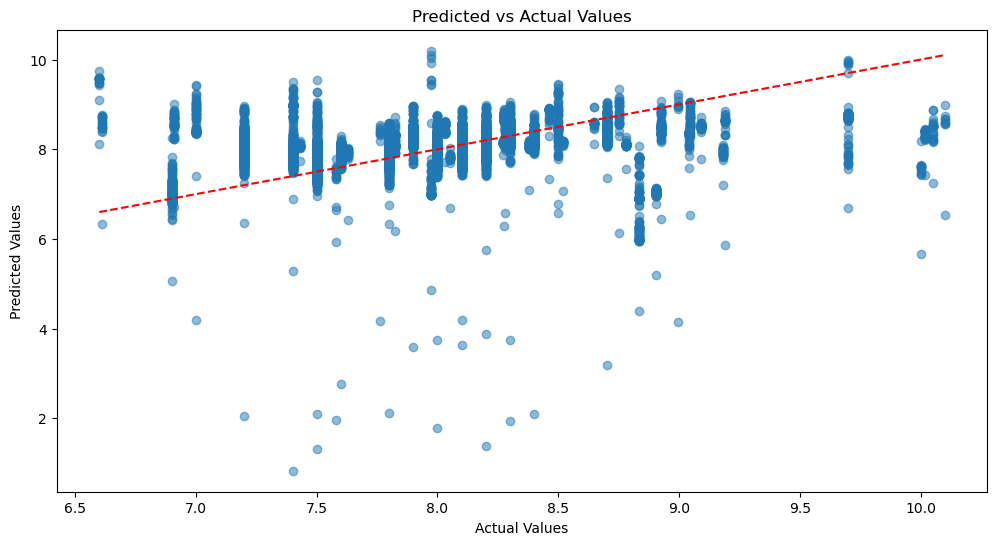

In [8]:
import matplotlib.pyplot as plt



# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Plot predicted vs actual values for the test set
y_pred = model.predict({'light_curve': X_lc_test, 'features': X_features_test})
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()